In [1]:
import numpy as np
from jax import jit, vmap, debug
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import os,sys,re
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
from itertools import cycle, islice
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         'image.cmap':'jet'}
plt.rcParams.update(params)
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)
from tqdm import tqdm
from EmuLP import Analysis, Template, Extinction, Galaxy, Filter

from collections import namedtuple
from functools import partial

2023-12-21 16:43:08.891394: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:497] The NVIDIA driver's CUDA version is 11.3 which is older than the ptxas CUDA version (11.4.152). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
summary_props = pd.read_pickle('FORS2_spectra_classif_properties_bothExt.pkl')
df_sl_spec = pd.read_pickle('FORS2-SL_spectra_for_templates_bothExt.pkl')

In [3]:
df_sl_spec.columns

Index(['Wavelength', 'SPEC_2_HZ4_BC_EBV0_Z0', 'SPEC_2_HZ4_BC_EBV0.067_Z0',
       'SPEC_2_HZ4_BC_EBV0.067_Z0.346', 'SPEC_3_HZ4_BC_EBV0_Z0',
       'SPEC_3_HZ4_BC_EBV0.076_Z0', 'SPEC_3_HZ4_BC_EBV0.076_Z0.687',
       'SPEC_9_HZ4_BC_EBV0_Z0', 'SPEC_9_HZ4_BC_EBV0.019_Z0',
       'SPEC_9_HZ4_BC_EBV0.019_Z0.293',
       ...
       'SPEC_735_HZ4_BC_EBV0.091_Z0.362', 'SPEC_736_HZ4_BC_EBV0_Z0',
       'SPEC_736_HZ4_BC_EBV0.201_Z0', 'SPEC_736_HZ4_BC_EBV0.201_Z0.558',
       'SPEC_737_HZ4_BC_EBV0_Z0', 'SPEC_737_HZ4_BC_EBV0.002_Z0',
       'SPEC_737_HZ4_BC_EBV0.002_Z0.520', 'SPEC_738_HZ4_BC_EBV0_Z0',
       'SPEC_738_HZ4_BC_EBV0.001_Z0', 'SPEC_738_HZ4_BC_EBV0.001_Z0.560'],
      dtype='object', length=1651)

In [4]:
summary_props

,FORS2-SL Id,RA[deg],DEC[deg],Redshift,M(cosmos_u_cfht),M(cosmos_u_new),M(hsc_gHSC),M(hsc_rHSC),M(hsc_iHSC),M(hsc_zHSC),...,M(hsc_iHSC)_z0_e0,M(hsc_zHSC)_z0_e0,M(hsc_yHSC)_z0_e0,Ext law,E(B-V),D4000n,NUVK,Type,Tag,Lines
0,2,13.52997,-28.44776,0.34555,25.656134,25.745916,24.930092,23.645802,22.995878,22.639219,...,9.576632,9.346443,9.088726,Calzetti,0.067182,0.731663,4.599056,E/S0,"SPEC2 , z=0.35, lines=K,H,G,H{beta}","b'K,H,G,H{beta} ..."
1,3,13.52552,-28.42080,0.68660,27.445406,27.456282,26.886576,25.794489,24.913620,24.694273,...,10.212948,10.127766,10.059660,Calzetti,0.076149,0.823350,3.359125,Sbc,"SPEC3 , z=0.69, lines=[OII],H9,K,H,H{beta},[OI...","b'[OII],H9,K,H,H{beta},[OIII],H8 ..."
2,9,13.50219,-28.40641,0.29266,25.645470,25.895012,24.405609,23.158213,22.570601,22.300610,...,9.830420,9.640383,9.454109,Calzetti,0.018776,0.643971,5.126751,E/S0,"SPEC9 , z=0.29, lines=H9,H8,K,H","b'H9,H8,K,H ..."
3,13,13.49261,-28.38272,0.68870,26.768324,26.846340,26.402250,26.112743,25.853102,25.812508,...,11.298798,11.133028,10.969179,Prevot,0.225470,1.034968,1.991021,Scd,"SPEC13 , z=0.69, lines=[OII],H{epsilon},H{delt...","b'[OII],H{epsilon},H{delta},H{beta} ..."
4,19,13.60758,-28.43452,0.48395,26.597130,26.724215,25.864109,24.474184,23.785151,23.457129,...,9.368839,9.169516,8.937725,Prevot,0.199623,0.806435,5.076760,E/S0,"SPEC19 , z=0.48, lines=H10,H9,H8,K,H,H{delta}","b'H10,H9,H8,K,H,H{delta} ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,734,13.68083,-28.23290,0.23012,21.852413,21.929195,21.131676,20.339006,19.937302,19.692709,...,7.437572,7.284735,7.114416,Prevot,0.224031,0.856026,3.635435,Sbc,"SPEC734 , z=0.23, lines=[OII],H9,K,H,H{alpha},NII","b'[OII],H9,K,H,H{alpha},NII ..."
546,735,13.69958,-28.23161,0.36169,23.979353,24.611977,22.326378,20.769735,20.153635,19.881050,...,6.829590,6.670799,6.471434,Prevot,0.091018,0.634273,7.225021,E/S0,"SPEC735 , z=0.36, lines=K,H,G,H{beta}","b'K,H,G,H{beta} ..."
547,736,13.66431,-28.22849,0.55777,26.097153,26.168510,25.715277,25.054239,24.657543,24.507502,...,10.399363,10.336321,10.274342,Prevot,0.201171,0.957919,2.254125,Scd,"SPEC736 , z=0.56, lines=[OII],H9,H{beta},[OIII]","b'[OII],H9,H{beta},[OIII] ..."
548,737,13.62722,-28.22692,0.52001,25.801903,25.909632,25.059542,23.921055,23.381739,23.152592,...,9.593592,9.502151,9.444016,Calzetti,0.001769,0.785689,2.974097,Scd,"SPEC737 , z=0.52, lines=[OII],K,H","b'[OII],K,H ..."


<AxesSubplot:xlabel='E(B-V)', ylabel='Probability'>

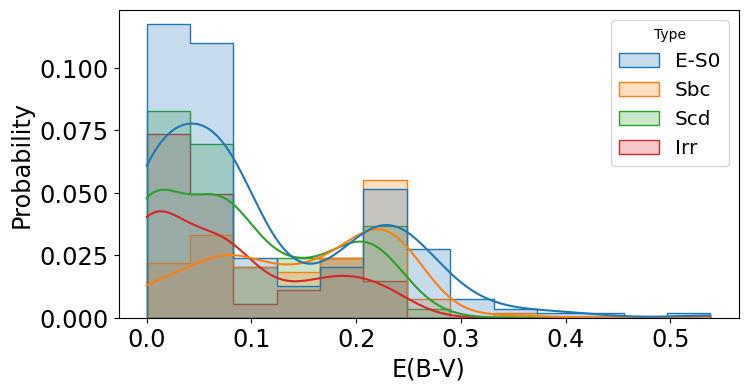

In [5]:
summary_props['Type'] = [ "E-S0" if typ=='E/S0' else typ for typ in summary_props['Type'].values ]
summary_props

sns.histplot(data=summary_props[summary_props['E(B-V)']<0.6], x='E(B-V)', hue='Type', stat='probability', multiple='layer', element='step', kde=True)

In [6]:
_sel = np.logical_and(summary_props['E(B-V)']<0.6, summary_props['Redshift']<1.6)
restricted_df = summary_props[_sel]
counts, edges = np.histogram(restricted_df['E(B-V)'].values, bins='auto')
edges

array([2.29337051e-14, 4.13981613e-02, 8.27963226e-02, 1.24194484e-01,
       1.65592645e-01, 2.06990806e-01, 2.48388968e-01, 2.89787129e-01,
       3.31185290e-01, 3.72583452e-01, 4.13981613e-01, 4.55379774e-01,
       4.96777936e-01, 5.38176097e-01])

In [7]:
np.histogram(restricted_df[restricted_df['Type']=='E/S0']['E(B-V)'].values, bins=edges)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([2.29337051e-14, 4.13981613e-02, 8.27963226e-02, 1.24194484e-01,
        1.65592645e-01, 2.06990806e-01, 2.48388968e-01, 2.89787129e-01,
        3.31185290e-01, 3.72583452e-01, 4.13981613e-01, 4.55379774e-01,
        4.96777936e-01, 5.38176097e-01]))

In [8]:
_sel = np.logical_and(np.logical_and(restricted_df['E(B-V)']>=edges[0],\
                                     restricted_df['E(B-V)']<edges[1]),\
                      restricted_df['Type']=='Irr')

In [9]:
restricted_df[_sel]['FORS2-SL Id'].values
nums = restricted_df[_sel]['FORS2-SL Id'].values
ebvs = restricted_df[_sel]['E(B-V)'].values
wls = df_sl_spec['Wavelength'].values
_nsel = np.logical_and(wls>1000., wls<10000.)
specs_to_stack = tuple(df_sl_spec[f'SPEC_{n}_HZ4_BC_EBV{ebv:.3f}_Z0'].values for (n,ebv) in zip(nums, ebvs))
specs = np.column_stack(specs_to_stack)
norms = np.trapz(specs[_nsel], x=wls[_nsel], axis=0)
specsN_to_stack = tuple(specs[:,j]/norms[j] for j in range(len(norms)))
normed_specs = jnp.column_stack(specsN_to_stack)

(0.0, 10000.0)

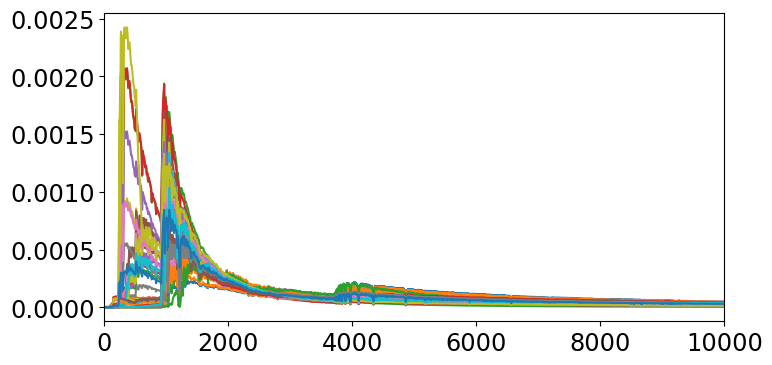

In [10]:
for j in range(normed_specs.shape[1]):
    plt.plot(wls, normed_specs[:,j])
avg_spec = np.mean(normed_specs, axis=1)
plt.plot(wls, avg_spec)
plt.xlim(0., 10000.)

(0.0, 10000.0)

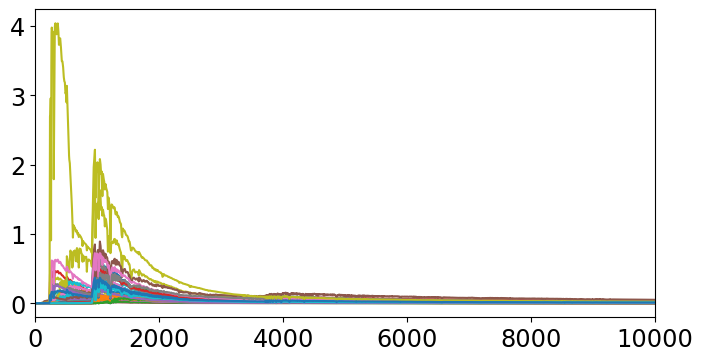

In [11]:
for j in range(specs.shape[1]):
    plt.plot(wls, specs[:,j])
avg_spec = np.mean(specs, axis=1)
plt.plot(wls, avg_spec)
plt.xlim(0., 10000.)

In [12]:
def avg_normed_spec(gal_type, ebv_low, ebv_high, ext_law="Calzetti"):
    _sel = np.logical_and(np.logical_and(np.logical_and(summary_props['E(B-V)']>ebv_low,\
                                                        summary_props['E(B-V)']<=ebv_high),\
                                         summary_props['Type']==gal_type),\
                          summary_props['Ext law']==ext_law)
    if np.any(_sel):
        print(f"Type: {gal_type}, {ext_law} dust extinction, avg E(B-V): {0.5*(e_inf+e_sup):.3f} - {len(_sel[_sel])} spectra")
        nums = summary_props[_sel]['FORS2-SL Id'].values
        ebvs = summary_props[_sel]['E(B-V)'].values
        wls = df_sl_spec['Wavelength'].values
        _nsel = np.logical_and(wls>1000., wls<10000.)
        specs_to_stack = tuple(df_sl_spec[f'SPEC_{n}_HZ4_BC_EBV{ebv:.3f}_Z0'].values for (n,ebv) in zip(nums, ebvs))
        specs = np.column_stack(specs_to_stack)
        norms = np.trapz(specs[_nsel], x=wls[_nsel], axis=0)
        specsN_to_stack = tuple(specs[:,j]/norms[j] for j in range(len(norms)))
        normed_specs = jnp.column_stack(specsN_to_stack)
        avg_spec = np.mean(normed_specs, axis=1)
        dev_spec = np.std(normed_specs, axis=1)
    else:
        avg_spec, dev_spec = None, None
    return avg_spec, dev_spec

def avg_spec(gal_type, ebv_low, ebv_high, ext_law="Calzetti"):
    _sel = np.logical_and(np.logical_and(np.logical_and(summary_props['E(B-V)']>ebv_low,\
                                                        summary_props['E(B-V)']<=ebv_high),\
                                         summary_props['Type']==gal_type),\
                          summary_props['Ext law']==ext_law)
    if np.any(_sel):
        print(f"Type: {gal_type}, {ext_law} dust extinction, avg E(B-V): {0.5*(e_inf+e_sup):.3f} - {len(_sel[_sel])} spectra")
        nums = summary_props[_sel]['FORS2-SL Id'].values
        ebvs = summary_props[_sel]['E(B-V)'].values
        wls = df_sl_spec['Wavelength'].values
        specs_to_stack = tuple(df_sl_spec[f'SPEC_{n}_HZ4_BC_EBV{ebv:.3f}_Z0'].values for (n,ebv) in zip(nums, ebvs))
        specs = np.column_stack(specs_to_stack)
        avg_spec = np.mean(specs, axis=1)
        dev_spec = np.std(specs, axis=1)
    else:
        avg_spec, dev_spec = None, None
    return avg_spec, dev_spec

def avg_spec_EBV0(gal_type, ebv_low, ebv_high, ext_law="Calzetti"):
    _sel = np.logical_and(np.logical_and(np.logical_and(summary_props['E(B-V)']>ebv_low,\
                                                        summary_props['E(B-V)']<=ebv_high),\
                                         summary_props['Type']==gal_type),\
                          summary_props['Ext law']==ext_law)
    if np.any(_sel):
        print(f"Type: {gal_type}, {ext_law} dust extinction, avg E(B-V): {0.5*(e_inf+e_sup):.3f} - {len(_sel[_sel])} spectra")
        nums = summary_props[_sel]['FORS2-SL Id'].values
        ebvs = summary_props[_sel]['E(B-V)'].values
        wls = df_sl_spec['Wavelength'].values
        specs_to_stack = tuple(df_sl_spec[f'SPEC_{n}_HZ4_BC_EBV0_Z0'].values for n in nums)
        specs = np.column_stack(specs_to_stack)
        avg_spec = np.mean(specs, axis=1)
        dev_spec = np.std(specs, axis=1)
    else:
        avg_spec, dev_spec = None, None
    return avg_spec, dev_spec

In [13]:
df_dusty_templates = pd.DataFrame()
df_dusty_templates['Wavelength'] = df_sl_spec['Wavelength'].values
for galtyp in np.unique(summary_props['Type'].values):
    for ext_law in np.unique(summary_props['Ext law'].values):
        for e_inf, e_sup in zip(edges[:-1], edges[1:]):
            avg_typ_ebv, sig_typ_ebv = avg_spec(galtyp, e_inf, e_sup, ext_law)
            if avg_typ_ebv is not None:
                df_dusty_templates[f'AVG_{galtyp}_{ext_law}_EBV{0.5*(e_inf+e_sup):.3f}'] = avg_typ_ebv
        
df_dusty_templates

Type: E-S0, Calzetti dust extinction, avg E(B-V): 0.021 - 46 spectra
Type: E-S0, Calzetti dust extinction, avg E(B-V): 0.062 - 50 spectra
Type: E-S0, Calzetti dust extinction, avg E(B-V): 0.103 - 2 spectra
Type: E-S0, Calzetti dust extinction, avg E(B-V): 0.228 - 1 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.021 - 17 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.062 - 10 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.103 - 11 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.145 - 7 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.186 - 11 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.228 - 27 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.269 - 15 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.310 - 4 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.352 - 2 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.393 - 1 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.435 - 1 sp

,Wavelength,AVG_E-S0_Calzetti_EBV0.021,AVG_E-S0_Calzetti_EBV0.062,AVG_E-S0_Calzetti_EBV0.103,AVG_E-S0_Calzetti_EBV0.228,AVG_E-S0_Prevot_EBV0.021,AVG_E-S0_Prevot_EBV0.062,AVG_E-S0_Prevot_EBV0.103,AVG_E-S0_Prevot_EBV0.145,AVG_E-S0_Prevot_EBV0.186,...,AVG_Scd_Calzetti_EBV0.062,AVG_Scd_Calzetti_EBV0.103,AVG_Scd_Calzetti_EBV0.228,AVG_Scd_Prevot_EBV0.021,AVG_Scd_Prevot_EBV0.062,AVG_Scd_Prevot_EBV0.103,AVG_Scd_Prevot_EBV0.145,AVG_Scd_Prevot_EBV0.186,AVG_Scd_Prevot_EBV0.228,AVG_Scd_Prevot_EBV0.269
0,1.0,0.000027,1.010932e-07,2.693310e-09,5.944880e-15,0.000113,0.000073,0.000150,0.000191,0.000561,...,3.076898e-07,1.379078e-08,5.910986e-14,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
1,2.0,0.000027,1.010932e-07,2.693310e-09,5.944880e-15,0.000113,0.000073,0.000150,0.000191,0.000561,...,3.076898e-07,1.379078e-08,5.910986e-14,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
2,3.0,0.000027,1.010932e-07,2.693310e-09,5.944880e-15,0.000113,0.000073,0.000150,0.000191,0.000561,...,3.076898e-07,1.379078e-08,5.910986e-14,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
3,4.0,0.000027,1.010932e-07,2.693310e-09,5.944880e-15,0.000113,0.000073,0.000150,0.000191,0.000561,...,3.076898e-07,1.379078e-08,5.910986e-14,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
4,5.0,0.000027,1.010932e-07,2.693310e-09,5.944880e-15,0.000113,0.000073,0.000150,0.000191,0.000561,...,3.076898e-07,1.379078e-08,5.910986e-14,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24996.0,0.013494,1.694809e-02,2.136196e-02,2.490232e-03,0.031074,0.010006,0.017639,0.008236,0.011011,...,5.965513e-03,1.358607e-02,3.795468e-03,0.003171,0.002272,0.003108,0.002975,0.001759,0.003464,0.001718
24996,24997.0,0.013496,1.694983e-02,2.136416e-02,2.490518e-03,0.031078,0.010007,0.017641,0.008236,0.011012,...,5.966169e-03,1.358794e-02,3.795896e-03,0.003172,0.002272,0.003108,0.002976,0.001759,0.003464,0.001718
24997,24998.0,0.013497,1.695157e-02,2.136635e-02,2.490804e-03,0.031081,0.010008,0.017642,0.008237,0.011013,...,5.966825e-03,1.358981e-02,3.796324e-03,0.003172,0.002272,0.003108,0.002976,0.001759,0.003465,0.001718
24998,24999.0,0.013499,1.695331e-02,2.136854e-02,2.491089e-03,0.031084,0.010009,0.017644,0.008238,0.011014,...,5.967482e-03,1.359169e-02,3.796752e-03,0.003172,0.002272,0.003109,0.002976,0.001759,0.003465,0.001719


In [14]:
df_EBV0_templates = pd.DataFrame()
df_EBV0_templates['Wavelength'] = df_sl_spec['Wavelength'].values
for galtyp in np.unique(summary_props['Type'].values):
    for ext_law in np.unique(summary_props['Ext law'].values):
        for e_inf, e_sup in zip(edges[:-1], edges[1:]):
            avg_typ_ebv, sig_typ_ebv = avg_spec_EBV0(galtyp, e_inf, e_sup, ext_law)
            if avg_typ_ebv is not None:
                df_EBV0_templates[f'AVG_{galtyp}_{ext_law}_EBV{0.5*(e_inf+e_sup):.3f}'] = avg_typ_ebv
        
df_EBV0_templates

Type: E-S0, Calzetti dust extinction, avg E(B-V): 0.021 - 46 spectra
Type: E-S0, Calzetti dust extinction, avg E(B-V): 0.062 - 50 spectra
Type: E-S0, Calzetti dust extinction, avg E(B-V): 0.103 - 2 spectra
Type: E-S0, Calzetti dust extinction, avg E(B-V): 0.228 - 1 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.021 - 17 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.062 - 10 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.103 - 11 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.145 - 7 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.186 - 11 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.228 - 27 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.269 - 15 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.310 - 4 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.352 - 2 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.393 - 1 spectra
Type: E-S0, Prevot dust extinction, avg E(B-V): 0.435 - 1 sp

,Wavelength,AVG_E-S0_Calzetti_EBV0.021,AVG_E-S0_Calzetti_EBV0.062,AVG_E-S0_Calzetti_EBV0.103,AVG_E-S0_Calzetti_EBV0.228,AVG_E-S0_Prevot_EBV0.021,AVG_E-S0_Prevot_EBV0.062,AVG_E-S0_Prevot_EBV0.103,AVG_E-S0_Prevot_EBV0.145,AVG_E-S0_Prevot_EBV0.186,...,AVG_Scd_Calzetti_EBV0.062,AVG_Scd_Calzetti_EBV0.103,AVG_Scd_Calzetti_EBV0.228,AVG_Scd_Prevot_EBV0.021,AVG_Scd_Prevot_EBV0.062,AVG_Scd_Prevot_EBV0.103,AVG_Scd_Prevot_EBV0.145,AVG_Scd_Prevot_EBV0.186,AVG_Scd_Prevot_EBV0.228,AVG_Scd_Prevot_EBV0.269
0,1.0,0.000070,0.000153,0.000165,0.000946,0.000113,0.000073,0.000150,0.000191,0.000561,...,0.000291,0.000305,0.000901,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
1,2.0,0.000070,0.000153,0.000165,0.000946,0.000113,0.000073,0.000150,0.000191,0.000561,...,0.000291,0.000305,0.000901,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
2,3.0,0.000070,0.000153,0.000165,0.000946,0.000113,0.000073,0.000150,0.000191,0.000561,...,0.000291,0.000305,0.000901,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
3,4.0,0.000070,0.000153,0.000165,0.000946,0.000113,0.000073,0.000150,0.000191,0.000561,...,0.000291,0.000305,0.000901,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
4,5.0,0.000070,0.000153,0.000165,0.000946,0.000113,0.000073,0.000150,0.000191,0.000561,...,0.000291,0.000305,0.000901,0.000180,0.000359,0.000617,0.002044,0.001375,0.001254,0.000363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24996.0,0.013525,0.017167,0.021741,0.002598,0.031141,0.010097,0.017925,0.008445,0.011380,...,0.006044,0.013817,0.003950,0.003172,0.002301,0.003168,0.003052,0.001817,0.003599,0.001798
24996,24997.0,0.013526,0.017169,0.021743,0.002598,0.031145,0.010098,0.017926,0.008446,0.011381,...,0.006045,0.013819,0.003951,0.003173,0.002302,0.003169,0.003052,0.001817,0.003600,0.001798
24997,24998.0,0.013528,0.017170,0.021745,0.002599,0.031148,0.010099,0.017928,0.008447,0.011383,...,0.006045,0.013821,0.003951,0.003173,0.002302,0.003169,0.003052,0.001817,0.003600,0.001798
24998,24999.0,0.013529,0.017172,0.021747,0.002599,0.031151,0.010100,0.017930,0.008448,0.011384,...,0.006046,0.013823,0.003951,0.003173,0.002302,0.003169,0.003053,0.001818,0.003601,0.001799


<AxesSubplot:xlabel='Wavelength'>

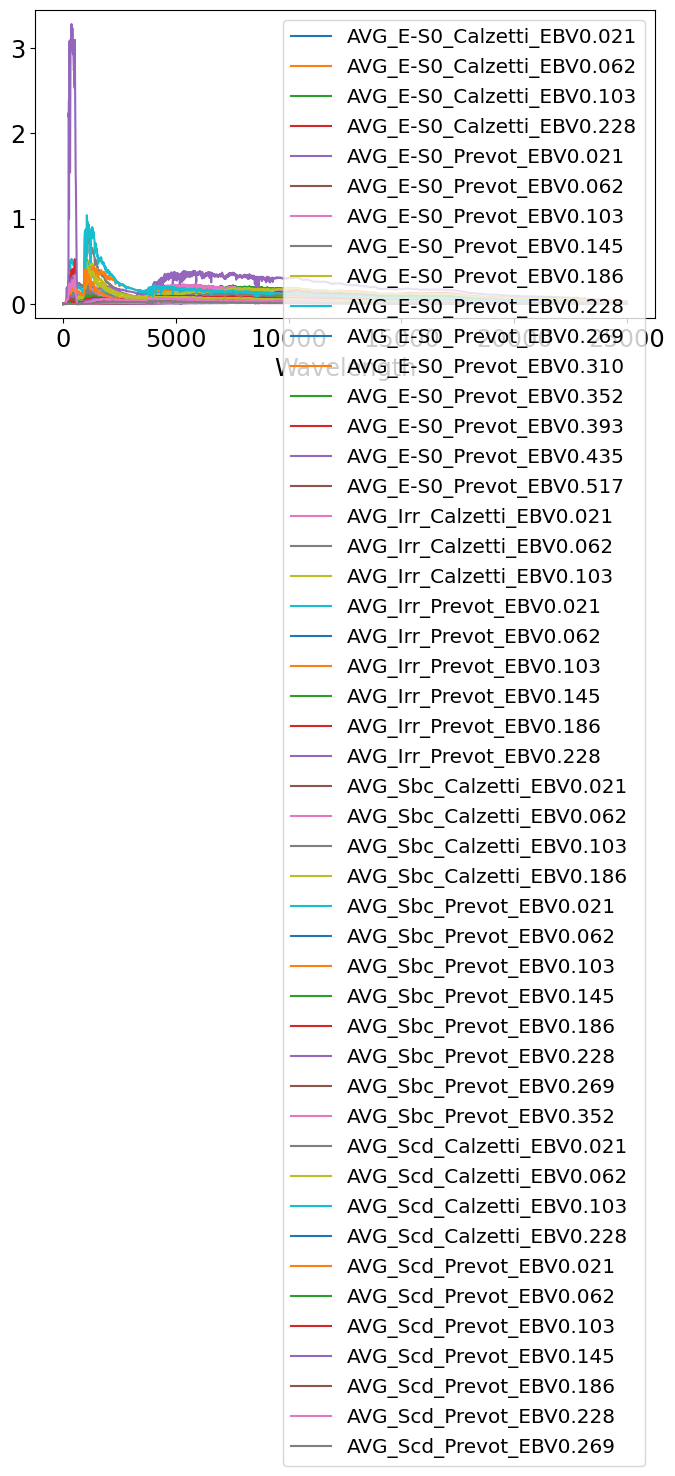

In [15]:
df_dusty_templates.plot(x='Wavelength')

<AxesSubplot:xlabel='Wavelength'>

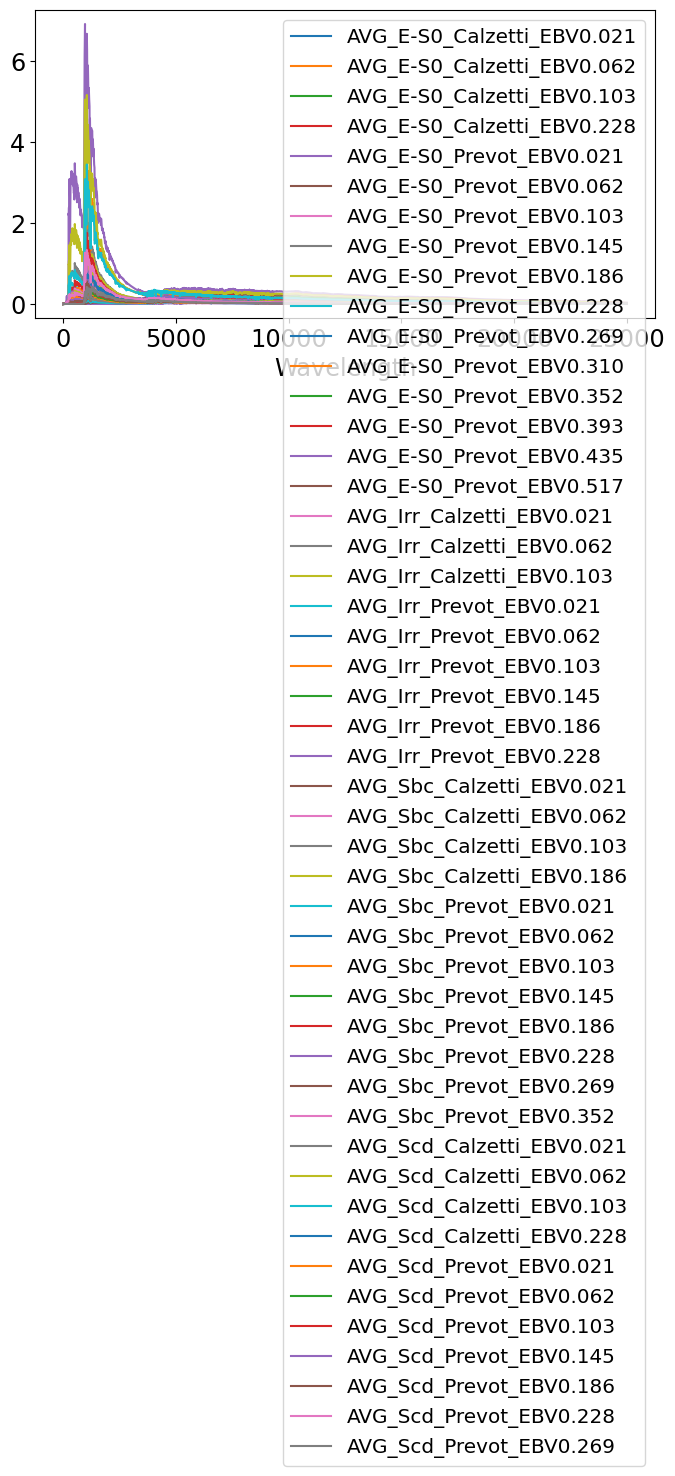

In [16]:
df_EBV0_templates.plot(x='Wavelength')

In [17]:
if os.getenv('LEPHAREDIR') is not None:
    LEPHAREDIR = os.getenv('LEPHAREDIR')
else:
    LEPHAREDIR = os.path.abspath(os.path.join(os.getcwd(), "LEPHARE"))
    os.environ['LEPHAREDIR'] = LEPHAREDIR
print(os.environ['LEPHAREDIR'])

lephare_res_dir = 'lephare_cosmos'
if os.getenv('LEPHAREWORK') is not None:
    LEPHAREWORK = os.environ['LEPHAREWORK']
else:
    LEPHAREWORK = os.path.abspath(os.path.join(os.getcwd(),lephare_res_dir))
    os.environ['LEPHAREWORK'] = LEPHAREWORK
print(os.environ['LEPHAREWORK'])

/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD/LEPHARE
/sps/lsst/groups/photoz/jocheval/PhotoZ_PhD/lephare_cosmos


In [18]:
_gal_seds = 'FORS2_DustySelect_batch7.1'
sed_dir = os.path.join(LEPHAREDIR, 'sed/GAL', _gal_seds)
if not os.path.isdir(sed_dir) : os.makedirs(sed_dir)
list_file_name = f'SED_FORS2_DustySelect_SL_v7.1'

In [19]:
if False:
    with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'w') as _l:
        _l.write(f'# FORS2-derived templates selected and averaged regarding their type and E(B-V) value\n')
    for _col in df_dusty_templates.columns[1:]:
        _arr = np.column_stack((df_dusty_templates['Wavelength'], df_dusty_templates[_col]))
        np.savetxt(os.path.join(sed_dir,f'{_col}.sed'), _arr, fmt=('%10.1f', '%10.8f'), delimiter=" ")
        with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'a') as _l:
            _l.write(_gal_seds+f'/{_col}.sed\n')

In [20]:
_gal_seds = 'FORS2_DustySelect_batch7.2'
sed_dir = os.path.join(LEPHAREDIR, 'sed/GAL', _gal_seds)
if not os.path.isdir(sed_dir) : os.makedirs(sed_dir)
list_file_name = f'SED_FORS2_DustySelect_SL_v7.2'

In [21]:
if False:
    with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'w') as _l:
        _l.write(f'# FORS2-derived templates selected and averaged regarding their type and E(B-V) value, without dust extinction\n')
    for _col in df_EBV0_templates.columns[1:]:
        _arr = np.column_stack((df_EBV0_templates['Wavelength'], df_EBV0_templates[_col]))
        np.savetxt(os.path.join(sed_dir,f'{_col}_noDust.sed'), _arr, fmt=('%10.1f', '%10.8f'), delimiter=" ")
        with open(os.path.join(LEPHAREWORK, list_file_name+'.list'), 'a') as _l:
            _l.write(_gal_seds+f'/{_col}_noDust.sed\n')

In [22]:
sorted(os.listdir(sed_dir))

['AVG_E-S0_Calzetti_EBV0.021_noDust.sed',
 'AVG_E-S0_Calzetti_EBV0.062_noDust.sed',
 'AVG_E-S0_Calzetti_EBV0.103_noDust.sed',
 'AVG_E-S0_Calzetti_EBV0.228_noDust.sed',
 'AVG_E-S0_Prevot_EBV0.021_noDust.sed',
 'AVG_E-S0_Prevot_EBV0.062_noDust.sed',
 'AVG_E-S0_Prevot_EBV0.103_noDust.sed',
 'AVG_E-S0_Prevot_EBV0.145_noDust.sed',
 'AVG_E-S0_Prevot_EBV0.186_noDust.sed',
 'AVG_E-S0_Prevot_EBV0.228_noDust.sed',
 'AVG_E-S0_Prevot_EBV0.269_noDust.sed',
 'AVG_E-S0_Prevot_EBV0.310_noDust.sed',
 'AVG_E-S0_Prevot_EBV0.352_noDust.sed',
 'AVG_E-S0_Prevot_EBV0.393_noDust.sed',
 'AVG_E-S0_Prevot_EBV0.435_noDust.sed',
 'AVG_E-S0_Prevot_EBV0.517_noDust.sed',
 'AVG_Irr_Calzetti_EBV0.021_noDust.sed',
 'AVG_Irr_Calzetti_EBV0.062_noDust.sed',
 'AVG_Irr_Calzetti_EBV0.103_noDust.sed',
 'AVG_Irr_Prevot_EBV0.021_noDust.sed',
 'AVG_Irr_Prevot_EBV0.062_noDust.sed',
 'AVG_Irr_Prevot_EBV0.103_noDust.sed',
 'AVG_Irr_Prevot_EBV0.145_noDust.sed',
 'AVG_Irr_Prevot_EBV0.186_noDust.sed',
 'AVG_Irr_Prevot_EBV0.228_noDust.s

## E(B-V) as a prior

### Select a sub-category

In [23]:
galtyp = "Sbc"
#sub_df = summary_props[summary_props["Type"]==galtyp]
sub_df = summary_props[summary_props["E(B-V)"]<0.6]

### Define a function to fit

In [24]:
# P(T|m0)
ktf = jnp.array([0.47165, 0.30663, 0.12715, -0.34437])
ft = jnp.array([0.43199, 0.07995, 0.31162, 0.21220])

@jit
def nebv_prior_core(ebv, imag, alpt0, zot, kt, pcal, ktf_m, ft_m):
    kk = imag-20.
    ebv_max = zot + kk
    pz = jnp.power(ebv, alpt0)*jnp.exp(-jnp.power(ebv/ebv_max, alpt0))

    # Ratio for each type
    rappSum = jnp.sum(ft*jnp.exp(-ktf*(imag-20.)))
    rapp = ft_m*jnp.exp(-ktf_m*(imag-20.))
    v2 = rapp/rappSum

    # Normalisation of the probability function
    _pcal=jnp.power(ebv_max, alpt0+1)/alpt0*pcal
    v1 = pz/_pcal

    # Final value
    val = v1 * v2
    return val
    #if not jnp.isfinite(val):
    #    val = 1.
    #return (val-1.)*jnp.isfinite(val).astype(float)+1.

In [25]:
@jit
def smail_nEBV(ebv, a, b, ebv0):
    return jnp.power(ebv, a) * jnp.exp(-jnp.power(ebv/ebv0, b))

In [26]:
from scipy.stats import gaussian_kde

In [27]:
gkde = gaussian_kde(sub_df["E(B-V)"].values)

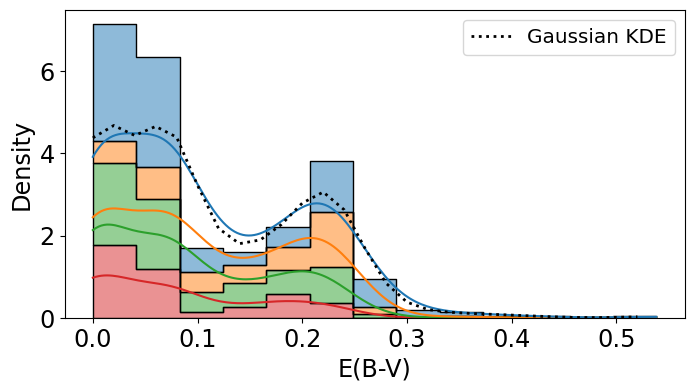

In [28]:
f,a = plt.subplots(1,1)
ebv_grid = jnp.arange(0., max(sub_df["E(B-V)"].values), 0.02)
sns.histplot(data=sub_df, x='E(B-V)', stat='density', hue='Type', element='step', multiple='stack', kde=True, ax=a)
a.plot(ebv_grid, gkde(ebv_grid), c='k', ls=':', lw=2, label='Gaussian KDE')
a.legend()

In [29]:
from scipy.optimize import curve_fit
res_fit = curve_fit(smail_nEBV, ebv_grid, gkde(ebv_grid))
res_fit

/opt/conda/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([7.56065341e-07, 3.92470851e+01, 3.00022797e-01]),
 array([[inf, inf, inf],
        [inf, inf, inf],
        [inf, inf, inf]]))

7.560653412702922e-07 39.24708507742778 0.3000227969174168


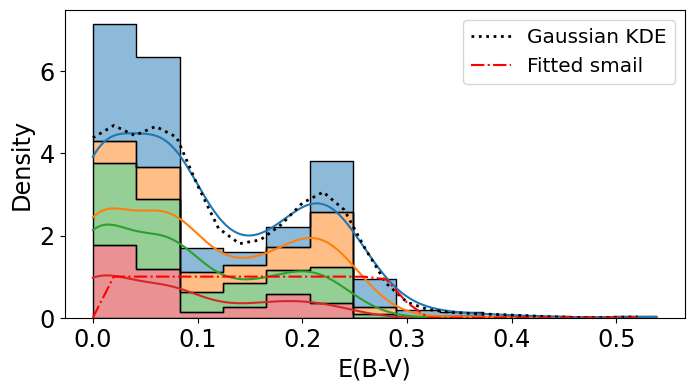

In [30]:
f,a = plt.subplots(1,1)
_a, _b, _ebv0 = res_fit[0]
print(_a, _b, _ebv0)
sns.histplot(data=sub_df, x='E(B-V)', stat='density', hue='Type', element='step', multiple='stack', kde=True, ax=a)
a.plot(ebv_grid, gkde(ebv_grid), c='k', ls=':', lw=2, label='Gaussian KDE')
a.plot(ebv_grid, smail_nEBV(ebv_grid, *res_fit[0]), c='red', ls='-.', label='Fitted smail')
a.legend()

In [31]:
@jit
def poly_nEBV(ebv, a, b, c, d, e, f, ebv0):
    return ebv0 + a*ebv + b*ebv**2 + c*ebv**3 + d*ebv**4 + e*ebv**5 + f*ebv**6
res_fit = curve_fit(poly_nEBV, ebv_grid, gkde(ebv_grid))
res_fit

(array([ 4.27766978e+01, -1.23346481e+03,  1.00325516e+04, -3.71520564e+04,
         6.36953244e+04, -4.09363952e+04,  4.36779491e+00]),
 array([[ 8.34362246e+02, -1.47663889e+04,  1.06130568e+05,
         -3.64013306e+05,  5.93932206e+05, -3.70935473e+05,
         -1.03286687e+01],
        [-1.47663889e+04,  2.86162044e+05, -2.16621493e+06,
          7.68107482e+06, -1.28191913e+07,  8.13474687e+06,
          1.45839501e+02],
        [ 1.06130568e+05, -2.16621493e+06,  1.69279801e+07,
         -6.13264073e+07,  1.03915559e+08, -6.66762035e+07,
         -9.30049925e+02],
        [-3.64013306e+05,  7.68107482e+06, -6.13264073e+07,
          2.25549048e+08, -3.86427271e+08,  2.50009948e+08,
          2.96493064e+03],
        [ 5.93932206e+05, -1.28191913e+07,  1.03915559e+08,
         -3.86427271e+08,  6.67584620e+08, -4.34689530e+08,
         -4.61040023e+03],
        [-3.70935473e+05,  8.13474687e+06, -6.66762035e+07,
          2.50009948e+08, -4.34689530e+08,  2.84477259e+08,
        

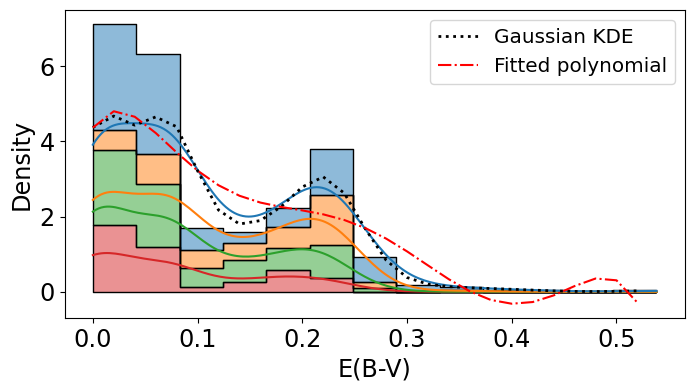

In [32]:
f,a = plt.subplots(1,1)
sns.histplot(data=sub_df, x='E(B-V)', stat='density', hue='Type', element='step', multiple='stack', kde=True, ax=a)
a.plot(ebv_grid, gkde(ebv_grid), c='k', ls=':', lw=2, label='Gaussian KDE')
a.plot(ebv_grid, poly_nEBV(ebv_grid, *res_fit[0]), c='red', ls='-.', label='Fitted polynomial')
a.legend()

In [33]:
@jit
def bigauss_nEBV(ebv, k1, mu1, sig1, k2, mu2, sig2):
    g1 = k1/sig1 * jnp.exp(-0.5*jnp.power((ebv - mu1)/sig1, 2.))
    g2 = k2/sig2 * jnp.exp(-0.5*jnp.power((ebv - mu2)/sig2, 2.))
    return (g1 + g2)/jnp.sqrt(2*jnp.pi)
res_fit = curve_fit(bigauss_nEBV, ebv_grid, gkde(ebv_grid))
res_fit

(array([0.27814895, 0.22024125, 0.03812739, 0.8390759 , 0.03656332,
        0.06909619]),
 array([[ 2.30369840e-04, -1.52181621e-05,  2.30624605e-05,
         -4.01662650e-04,  1.14602726e-05, -4.06022124e-05],
        [-1.52181621e-05,  4.17680080e-06, -1.62914690e-06,
          4.54038062e-05, -1.22143403e-06,  4.58983650e-06],
        [ 2.30624605e-05, -1.62914690e-06,  3.97550849e-06,
         -4.07461675e-05,  8.18384864e-07, -4.07233620e-06],
        [-4.01662650e-04,  4.54038062e-05, -4.07461675e-05,
          1.59005693e-03, -7.93571613e-05,  1.44244379e-04],
        [ 1.14602726e-05, -1.22143403e-06,  8.18384864e-07,
         -7.93571613e-05,  7.65026746e-06, -7.20079214e-06],
        [-4.06022124e-05,  4.58983650e-06, -4.07233620e-06,
          1.44244379e-04, -7.20079214e-06,  1.45781364e-05]]))

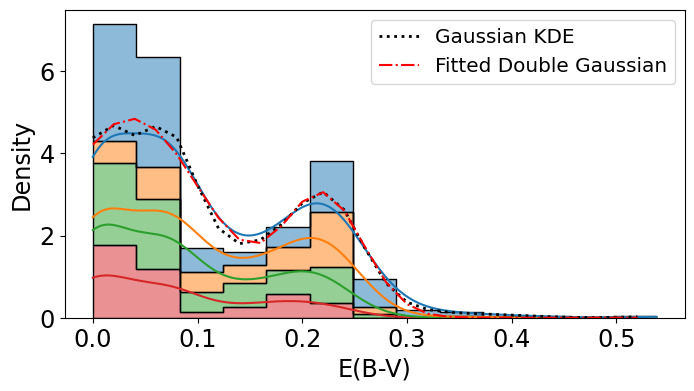

In [34]:
f,a = plt.subplots(1,1)
sns.histplot(data=sub_df, x='E(B-V)', stat='density', hue='Type', element='step', multiple='stack', kde=True, ax=a)
a.plot(ebv_grid, gkde(ebv_grid), c='k', ls=':', lw=2, label='Gaussian KDE')
a.plot(ebv_grid, bigauss_nEBV(ebv_grid, *res_fit[0]), c='red', ls='-.', label='Fitted Double Gaussian')
a.legend()

In [35]:
g2d_kde = gaussian_kde(jnp.row_stack((sub_df["E(B-V)"].values, sub_df["NUVK"].values)))

<AxesSubplot:xlabel='E(B-V)', ylabel='NUVK'>

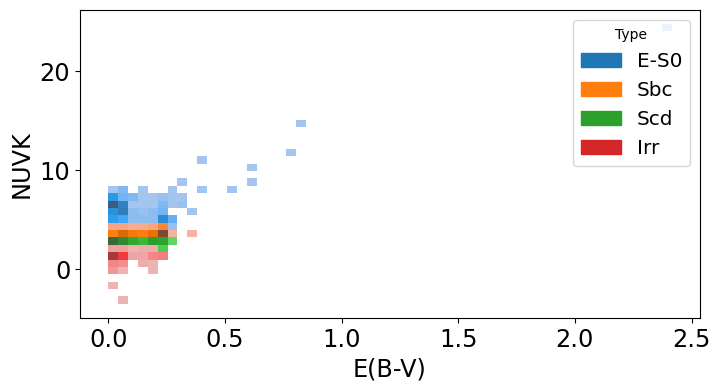

In [36]:
sns.histplot(data=summary_props, x='E(B-V)', y='NUVK', hue='Type', stat='count', multiple='dodge', element='step', kde=True)

In [37]:
nuvk_grid = jnp.arange(0., max(sub_df["NUVK"].values), 0.01)

In [38]:
kde_arr = jnp.array([[g2d_kde((i,j))[0] for i in ebv_grid] for j in nuvk_grid])
kde_arr.shape

(1088, 27)

In [39]:
kde_arr

DeviceArray([[1.7624560e-01, 1.7176887e-01, 1.4618973e-01, ...,
              3.2041337e-13, 1.2594072e-14, 3.3534789e-16],
             [1.7855622e-01, 1.7419846e-01, 1.4845356e-01, ...,
              3.4739049e-13, 1.3670311e-14, 3.6442362e-16],
             [1.8088886e-01, 1.7665376e-01, 1.5074417e-01, ...,
              3.7656025e-13, 1.4835411e-14, 3.9593727e-16],
             ...,
             [1.4581441e-06, 3.3011449e-06, 7.4352743e-06, ...,
              1.7624622e-03, 4.1813147e-04, 7.3165960e-05],
             [1.3680325e-06, 3.1033517e-06, 7.0029682e-06, ...,
              1.7696142e-03, 4.2014298e-04, 7.3214964e-05],
             [1.2832390e-06, 2.9168384e-06, 6.5944851e-06, ...,
              1.7764260e-03, 4.2208645e-04, 7.3271636e-05]],            dtype=float32)

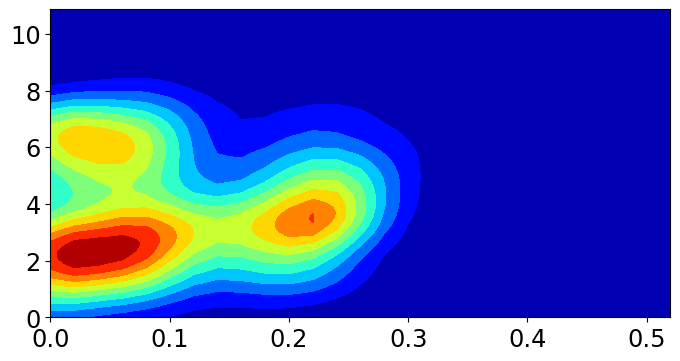

In [40]:
plt.contourf(ebv_grid, nuvk_grid, kde_arr, levels=10)

<AxesSubplot:xlabel='D4000n', ylabel='E(B-V)'>

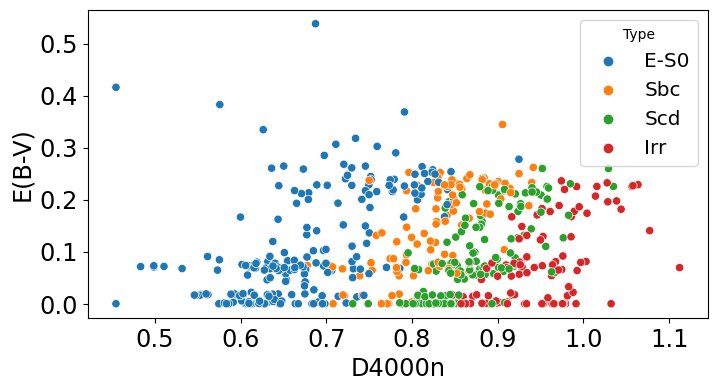

In [41]:
sns.scatterplot(data=sub_df, x="D4000n", y="E(B-V)", hue="Type")

In [42]:
trunc_df = summary_props.iloc[:, [1,2,3,-7,-6,-5,-4]].copy()
trunc_df

,RA[deg],DEC[deg],Redshift,Ext law,E(B-V),D4000n,NUVK
0,13.52997,-28.44776,0.34555,Calzetti,0.067182,0.731663,4.599056
1,13.52552,-28.42080,0.68660,Calzetti,0.076149,0.823350,3.359125
2,13.50219,-28.40641,0.29266,Calzetti,0.018776,0.643971,5.126751
3,13.49261,-28.38272,0.68870,Prevot,0.225470,1.034968,1.991021
4,13.60758,-28.43452,0.48395,Prevot,0.199623,0.806435,5.076760
...,...,...,...,...,...,...,...
545,13.68083,-28.23290,0.23012,Prevot,0.224031,0.856026,3.635435
546,13.69958,-28.23161,0.36169,Prevot,0.091018,0.634273,7.225021
547,13.66431,-28.22849,0.55777,Prevot,0.201171,0.957919,2.254125
548,13.62722,-28.22692,0.52001,Calzetti,0.001769,0.785689,2.974097


<AxesSubplot:>

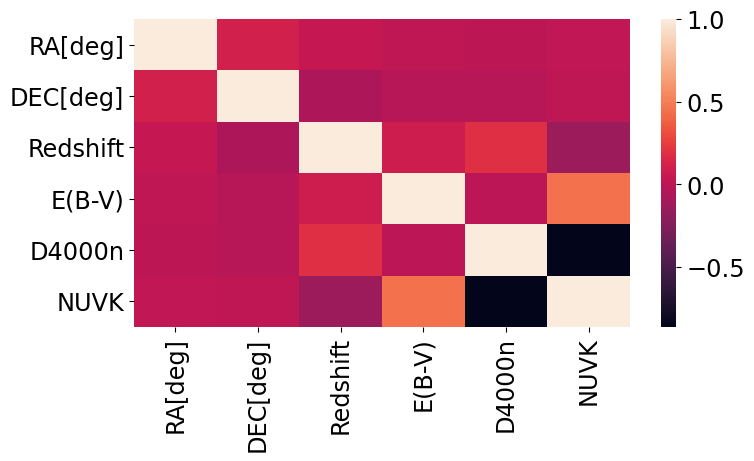

In [43]:
corr = trunc_df.corr(numeric_only=True)
sns.heatmap(corr)

In [44]:
corr

,RA[deg],DEC[deg],Redshift,E(B-V),D4000n,NUVK
RA[deg],1.000000,0.109404,0.047733,0.018413,0.006292,0.022889
DEC[deg],0.109404,1.000000,-0.062805,-0.022405,-0.022811,0.018609
Redshift,0.047733,-0.062805,1.000000,0.081346,0.188190,-0.134161
E(B-V),0.018413,-0.022405,0.081346,1.000000,-0.000096,0.443338
D4000n,0.006292,-0.022811,0.188190,-0.000096,1.000000,-0.860069
NUVK,0.022889,0.018609,-0.134161,0.443338,-0.860069,1.000000


In [45]:
#g2d_kde = gaussian_kde(jnp.row_stack((sub_df["E(B-V) (Calzetti)"].values, sub_df["M(hsc_iHSC)_z0_e0"].values)))
g2d_kde = gaussian_kde(jnp.row_stack((sub_df["E(B-V)"].values, sub_df["Redshift"].values)))

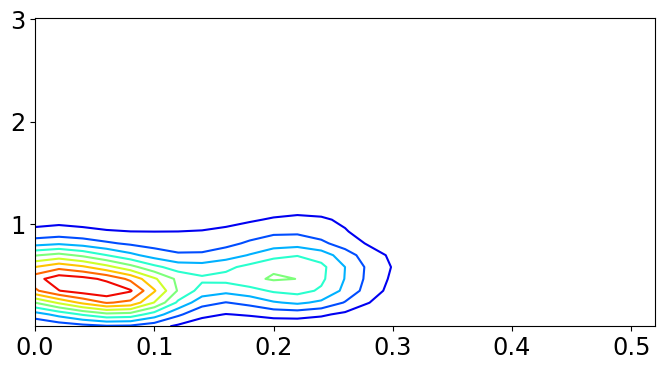

In [46]:
z_grid = jnp.linspace(0.001, 3.011, len(ebv_grid))
mi_grid = jnp.linspace(min(sub_df["M(hsc_iHSC)_z0_e0"].values), max(sub_df["M(hsc_iHSC)_z0_e0"].values), len(ebv_grid))
kde_arr = jnp.array([[g2d_kde((i,j))[0] for i in ebv_grid] for j in z_grid])
plt.contour(ebv_grid, z_grid, kde_arr, levels=10)

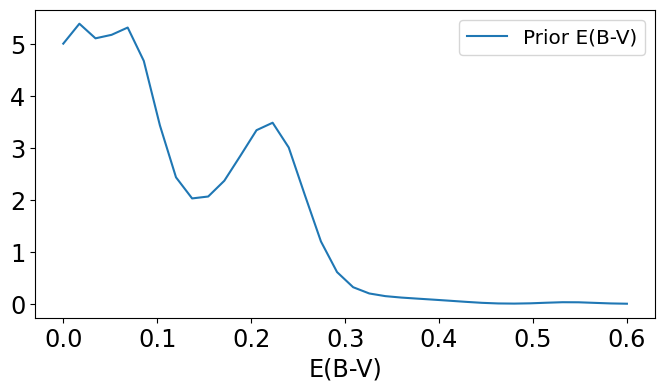

In [47]:
ebv_grid = jnp.linspace(0., 0.6, 36)
ebv_prior_df = pd.DataFrame()
ebv_prior_df["E(B-V)"] = ebv_grid
gkde = gaussian_kde(restricted_df["E(B-V)"].values)
gkde_eval = gkde(ebv_grid)
ebv_prior_df["Prior E(B-V)"] = gkde_eval / jnp.trapz(gkde_eval, ebv_grid)
ebv_prior_df.plot(x='E(B-V)')
if False: ebv_prior_df.to_pickle('EmuLP/NoType_NoLaw_ebv_prior_dataframe_fromFORS2.pkl')

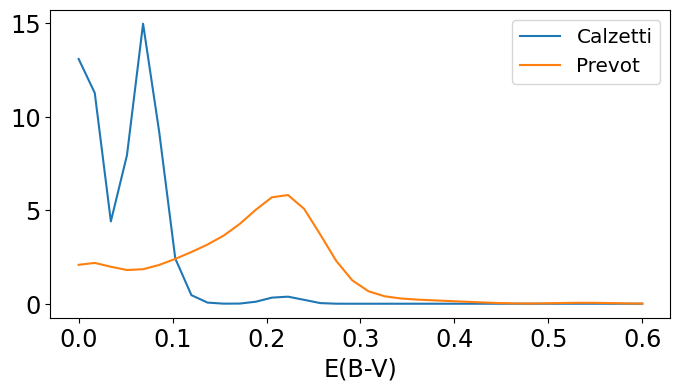

In [48]:
ebv_grid = jnp.linspace(0., 0.6, 36)
ebv_prior_df = pd.DataFrame()
ebv_prior_df["E(B-V)"] = ebv_grid
for ext_law in ['Calzetti', 'Prevot']:
    _sel = restricted_df["Ext law"]==ext_law
    sub_df = restricted_df[_sel]
    if len(sub_df["E(B-V)"].values) > 1 :
        gkde = gaussian_kde(sub_df["E(B-V)"].values)
        gkde_eval = gkde(ebv_grid)
    else :
        gkde_eval = np.ones_like(ebv_grid)
    ebv_prior_df[ext_law] = gkde_eval / jnp.trapz(gkde_eval, ebv_grid)
ebv_prior_df.plot(x='E(B-V)')
if False: ebv_prior_df.to_pickle('EmuLP/NoType_ebv_prior_dataframe_fromFORS2.pkl')

E-S0_Calzetti
1.0
E-S0_Prevot
1.0
Sbc_Calzetti
1.0
Sbc_Prevot
1.0
Scd_Calzetti
1.0
Scd_Prevot
1.0
Irr_Calzetti
0.9999999
Irr_Prevot
1.0000001


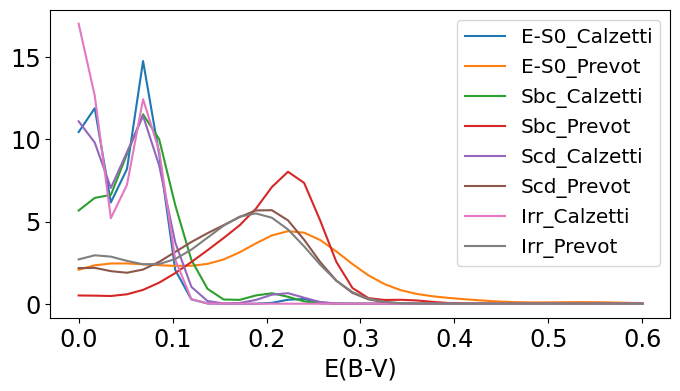

In [49]:
ebv_grid = jnp.linspace(0., 0.6, 36)
ebv_prior_df = pd.DataFrame()
ebv_prior_df["E(B-V)"] = ebv_grid
for galtyp in ['E-S0', 'Sbc', 'Scd', 'Irr']:
    for ext_law in ['Calzetti', 'Prevot']:
        _sel = np.logical_and(restricted_df["Type"]==galtyp, restricted_df["Ext law"]==ext_law)
        print(f"{galtyp}_{ext_law}")
        sub_df = restricted_df[_sel]
        if len(sub_df["E(B-V)"].values) > 1 :
            gkde = gaussian_kde(sub_df["E(B-V)"].values)
            gkde_eval = gkde(ebv_grid)
        else :
            gkde_eval = np.ones_like(ebv_grid)
        ebv_prior_df[f"{galtyp}_{ext_law}"] = gkde_eval / jnp.trapz(gkde_eval, ebv_grid)
        print(jnp.trapz(ebv_prior_df[f"{galtyp}_{ext_law}"].values, ebv_grid))
ebv_prior_df.plot(x='E(B-V)')
if False: ebv_prior_df.to_pickle('EmuLP/BothExt_ebv_prior_dataframe_fromFORS2.pkl')

In [50]:
ebv_prior_df

,E(B-V),E-S0_Calzetti,E-S0_Prevot,Sbc_Calzetti,Sbc_Prevot,Scd_Calzetti,Scd_Prevot,Irr_Calzetti,Irr_Prevot
0,0.000000,1.044568e+01,2.066994,5.672650e+00,5.018003e-01,1.109665e+01,2.167791e+00,1.703839e+01,2.697711e+00
1,0.017143,1.190019e+01,2.336229,6.440468e+00,4.918031e-01,9.803590e+00,2.181749e+00,1.265548e+01,2.946720e+00
2,0.034286,6.165545e+00,2.448393,6.619930e+00,4.700498e-01,7.044240e+00,1.982466e+00,5.207420e+00,2.865871e+00
3,0.051429,8.192818e+00,2.450351,9.102690e+00,5.730123e-01,9.223125e+00,1.884675e+00,7.230654e+00,2.608111e+00
4,0.068571,1.476749e+01,2.401980,1.152552e+01,8.431880e-01,1.143071e+01,2.080247e+00,1.244634e+01,2.398367e+00
5,0.085714,9.080826e+00,2.343873,1.001163e+01,1.281419e+00,8.410143e+00,2.547531e+00,9.305164e+00,2.413196e+00
6,0.102857,2.046008e+00,2.301854,5.992513e+00,1.865283e+00,3.717420e+00,3.151655e+00,2.672748e+00,2.721590e+00
7,0.120000,2.634940e-01,2.310531,2.668996e+00,2.537558e+00,1.025212e+00,3.756124e+00,2.850317e-01,3.291103e+00
8,0.137143,1.945418e-02,2.423268,9.086052e-01,3.254681e+00,1.655025e-01,4.290616e+00,1.113622e-02,4.017640e+00
9,0.154286,4.880921e-04,2.692785,2.570787e-01,3.996231e+00,1.798540e-02,4.781501e+00,1.542919e-04,4.747603e+00
